In [1]:
# General
import numpy as np 
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.model_selection as cv
import random
import missingno as msno


C:\Users\wanyi\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df_train = pd.read_csv("C:/Users/wanyi/Desktop/Data Mining/Assignment_3/Loan_Prediction/Submission Package/train.csv")
df_test = pd.read_csv("C:/Users/wanyi/Desktop/Data Mining/Assignment_3/Loan_Prediction/Submission Package/test.csv")

C:\Users\wanyi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Step 1: Data dropping based on:
* 1) nature of columns
* 2) business accumen
* 3) proportion of missing value

In [4]:
df_train.head()
column_names_train = df_train.columns.tolist()
column_names_test = df_test.columns.tolist()

In [5]:
def cal_missing_val(df):
    data_dict = {}
    for col in df.columns:
        data_dict[col] = df[col].isnull().sum()/df.shape[0]*100
    return pd.DataFrame.from_dict(data_dict, orient='index', columns=['MissingValue'])

In [6]:
data_missing=cal_missing_val(df_train)
data_missing.sort_values(by=["MissingValue"],ascending = False)

,MissingValue
X26,87.21125
X16,69.11000
X25,54.70050
X12,15.34025
X8,15.31750
X9,15.31750
X13,15.25700
X1,15.25250
X10,5.99650
X11,4.38450


In [7]:
data_missing=cal_missing_val(df_test)
data_missing.sort_values(by=["MissingValue"], ascending = False)

,MissingValue
X1,100.00000
X16,99.98125
X26,82.70125
X25,48.38000
X10,5.49250
X11,5.47750
X30,0.03750
X29,0.00000
X28,0.00000
X27,0.00000


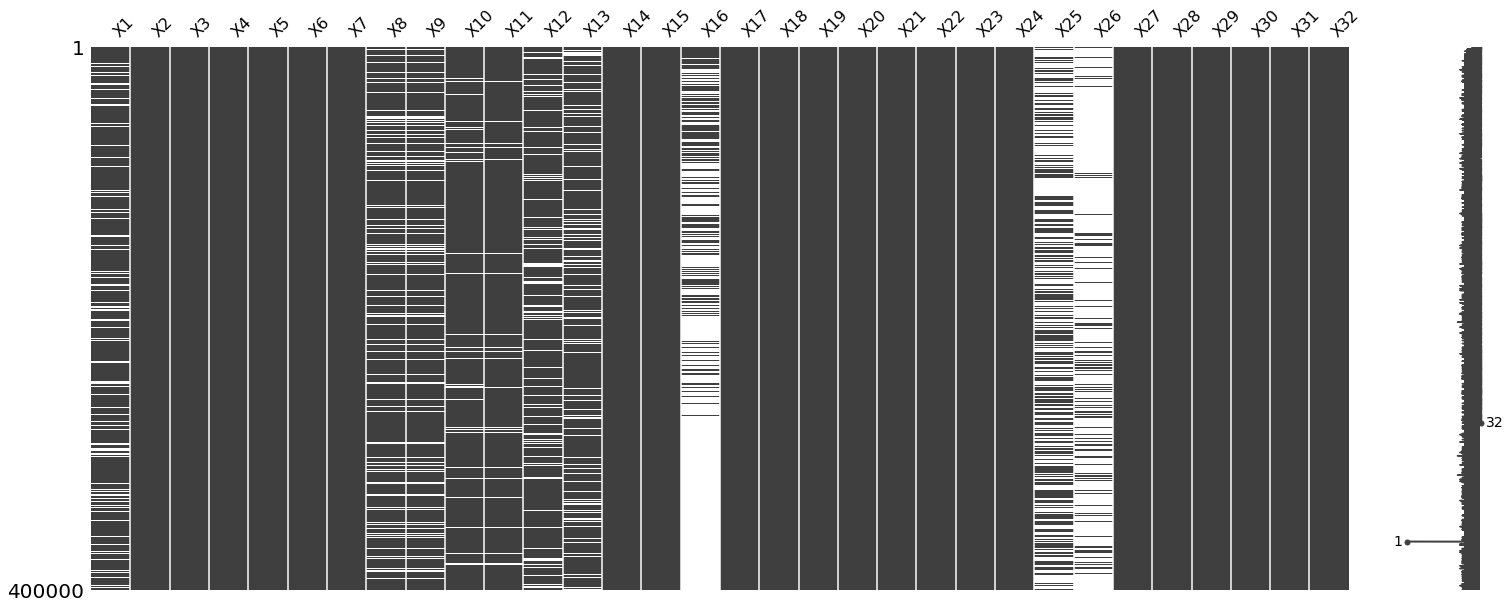

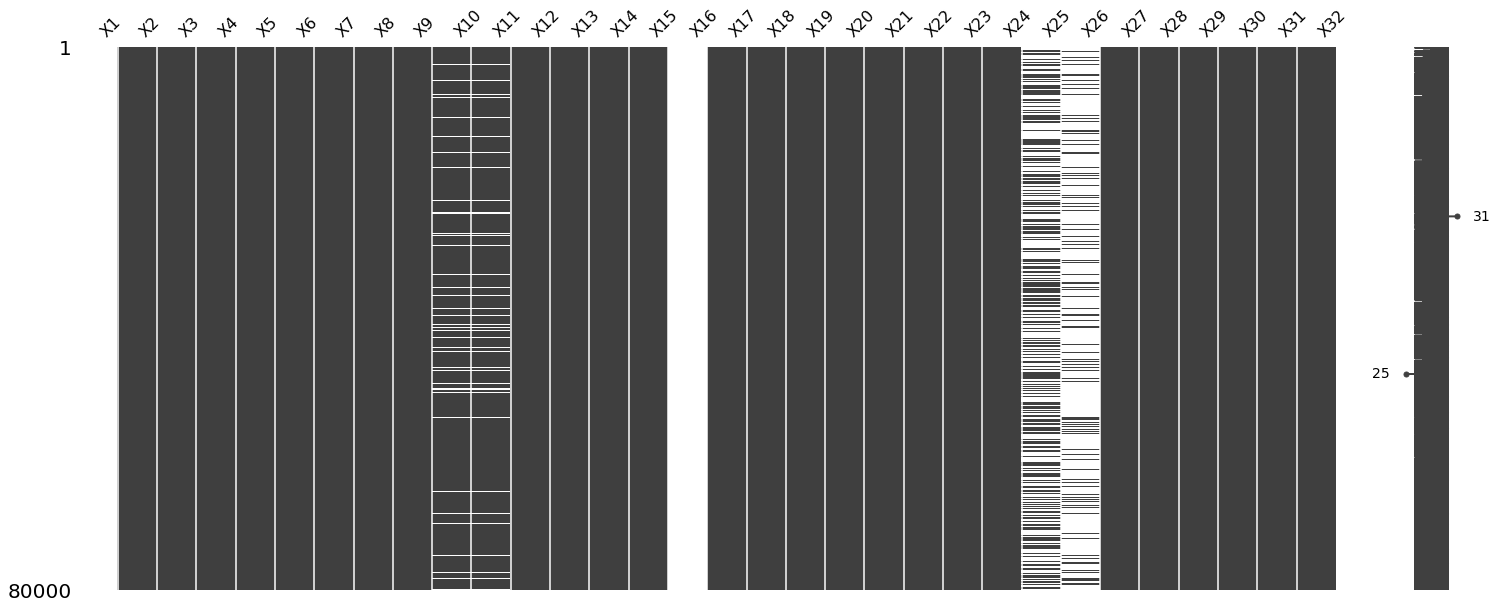

In [8]:
msno.matrix(df_train[column_names_train])
msno.matrix(df_test[column_names_test])

In [9]:
# text, symbol, data formating cleaning 
data = [df_train, df_test]
for dataset in data:
    dataset.X1 = dataset.X1.replace('%','',regex = True).astype(float)/100
    dataset.X4 = dataset.X4.replace('[\$,]','',regex = True).astype(float)
    dataset.X5 = dataset.X5.replace('[$,]','',regex = True).astype(float)
    dataset.X6 = dataset.X6.replace('[\$,]','',regex = True).astype(float)
    dataset.X30 = dataset.X30.replace('%','',regex = True).astype(float)
    dataset.X13 = dataset.X13.astype(float)
    

In [10]:
# Dropping high NA columns OR useless columns (such as loan id, date loan was issued,loan title, job title) for both train and test.
data = [df_train,df_test]

df_train = df_train.drop(columns = ['X2','X3','X10','X15','X16','X18','X23','X25','X26'])
df_test = df_test.drop(columns = ['X2','X3','X10','X15','X16','X18','X23','X25','X26'])

In [11]:
'''
msno.matrix(df_train[df_train.columns])
msno.matrix(df_test[df_test.columns])
'''

'\nmsno.matrix(df_train[df_train.columns])\nmsno.matrix(df_test[df_test.columns])\n'

In [12]:
# Removing if the rows have more than 10 value missing 
df_test = df_test[df_test.isnull().sum(axis=1) < 10]
df_train = df_train[df_train.isnull().sum(axis=1) < 10]

In [13]:
print(df_test.shape)
df_train.shape

(80000, 23)


(399999, 23)

# Step 2: Missing value imputation

In [14]:
data_missing=cal_missing_val(df_train)
data_missing.sort_values(by=["MissingValue"], ascending = False).head(10)

,MissingValue
X12,15.340038
X8,15.317288
X9,15.317288
X13,15.256788
X1,15.252538
X11,4.384261
X30,0.066500
X21,0.000000
X31,0.000000
X29,0.000000


In [15]:
data_missing=cal_missing_val(df_test)
data_missing.sort_values(by=["MissingValue"], ascending = False).head()

,MissingValue
X1,100.0000
X11,5.4775
X30,0.0375
X19,0.0000
X31,0.0000


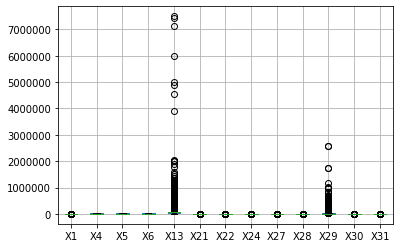

In [16]:
df_train.boxplot()

Based on the summary above: 
* For training: imputing columns X8,X9,X11,X12,X13
* For testing: imputing columns X11

X13 annual income inputing with median 

In [17]:
df_train['X13'].describe()

count    3.389720e+05
mean     7.316015e+04
std      5.586770e+04
min      3.000000e+03
25%      4.500000e+04
50%      6.300000e+04
75%      8.820000e+04
max      7.500000e+06
Name: X13, dtype: float64

In [18]:
# Fill X13 annual income with median. Mean is not appropriate as X13 has outliers. 
fillvalue = np.nanmedian(df_train['X13'])
df_train['X13'].fillna(fillvalue, inplace=True)

In [19]:
fillvalue = np.nanmedian(df_test['X13'])
df_test['X13'].fillna(fillvalue, inplace=True)

X11 number of years of working median 

In [20]:
df_train.X11 = df_train.X11.replace('n/a','',regex = True)

In [21]:
from scipy import stats
m1 = stats.mode(df_train.X11.to_numpy())
df_train['X11'].fillna(m1[0][0], inplace=True)

In [22]:
m2 = stats.mode(df_test.X11.to_numpy())
df_test['X11'].fillna(m2[0][0], inplace=True)

In [23]:
data = [df_train, df_test]
for dataset in data:
    dataset.X11 = dataset.X11.replace('years','',regex = True)
    dataset.X11 = dataset.X11.replace('year','',regex = True)
    dataset.X11 = dataset.X11.replace('< 1','1',regex = True)
    #dataset.X11 = dataset.X11.replace('','',regex = True)

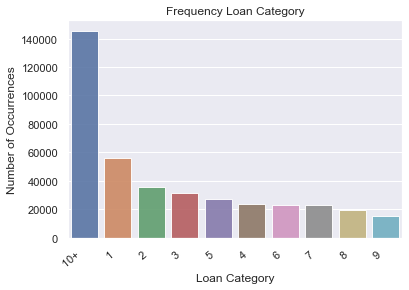

In [24]:
loan_cat = df_train['X11'].value_counts()
sns.set(style="darkgrid")
ax = sns.barplot(loan_cat.index, loan_cat.values, alpha=0.9,)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right") #make the x axis readable 
plt.title('Frequency Loan Category')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan Category', fontsize=12)
plt.show()

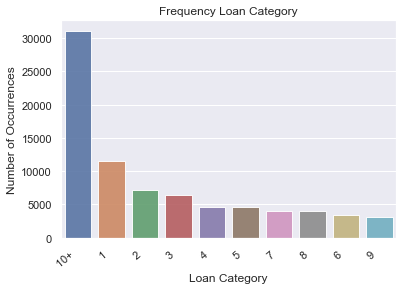

In [25]:
loan_cat = df_test['X11'].value_counts()
sns.set(style="darkgrid")
ax = sns.barplot(loan_cat.index, loan_cat.values, alpha=0.9,)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right") #make the x axis readable 
plt.title('Frequency Loan Category')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan Category', fontsize=12)
plt.show()

In [26]:
df_train = pd.get_dummies(df_train, columns = ['X11'])
df_test = pd.get_dummies(df_test, columns = ['X11'])

X8 and X9 are important based on annual income (X13) as this is the major factor to impact the credit rating.

In [27]:
loan_grade={'A': 1,'B': 2, 'C': 3,'D': 4, 'E': 5, 'F': 6, 'G': 7}
loan_subgrade = {'A1': 11, 'A2': 12, 'A3': 13, 'A4': 14, 'A5': 15,
'B1': 21, 'B2': 22, 'B3': 23, 'B4': 24, 'B5': 25,
'C1': 31,'C2': 32, 'C3': 33, 'C4': 34, 'C5': 35,
'D1': 41, 'D2': 42, 'D3': 43, 'D4': 44, 'D5': 45,
'E1': 51, 'E2': 52,'E3': 53, 'E4': 54, 'E5': 55,
'F1': 61, 'F2': 62, 'F3': 63, 'F4': 64, 'F5': 66,
'G1': 71, 'G2': 71, 'G3': 73,'G4': 74, 'G5': 75}

In [28]:
data = [df_train, df_test]
for dataset in data:
    dataset['X8'] = dataset['X8'].map(loan_grade)
    dataset['X9'] = dataset['X9'].map(loan_subgrade)

In [29]:
# CREATE A RANGE FOR INCOME ??????????



In [30]:
#Step 1 Get missing values filled from similar customer by groupby
df_train['X9'] = df_train.groupby('X13')['X9'].transform(lambda x: x.fillna(stats.mode(x)[0][0]))
df_train['X8'] = df_train.groupby('X13')['X8'].transform(lambda x: x.fillna(stats.mode(x)[0][0]))

In [31]:
#Step 2 get missing values filled by median
df_train['X9'].fillna(np.nanmedian(df_train['X9']), inplace=True)
df_train['X8'].fillna(np.nanmedian(df_train['X8']), inplace=True)

In [32]:
# checking no missing value after step 1 and 2 
df_train['X8'].isnull().sum()
df_train['X9'].isnull().sum()

0

X12 Inputation NA with "NONE" --> one hot encoding - drop useless columns 

In [33]:
df_train['X12'].fillna('NONE', inplace = True)
df_test['X12'].fillna('NONE', inplace = True)
df_train = pd.get_dummies(df_train, columns =['X12']) 
df_train = df_train.drop(['X12_NONE','X12_ANY','X12_OTHER'], axis= 1)
df_test = pd.get_dummies(df_test, columns =['X12'])

x14 --> label encoding --> one hot encoding 

In [34]:
Verification= {'VERIFIED - income': 0,'not verified': 1,'VERIFIED - income source': 2}
df_train['X14'] = df_train['X14'].map(Verification)
df_train = pd.get_dummies(df_train, columns =['X14']) 
df_test['X14'] = df_test['X14'].map(Verification)
df_test = pd.get_dummies(df_test, columns =['X14']) 

X7 --> delete month 

In [35]:
data = [df_train, df_test]
for dataset in data:
    dataset.X7 = dataset.X7.replace('months','',regex = True)
    dataset.X7 = dataset.X7.replace('36','0',regex = True)
    dataset.X7 = dataset.X7.replace('60','1',regex = True)
    dataset.X7 = dataset.X7.astype(int)

In [36]:
df_train['X7'].isnull().sum()
df_test['X7'].isnull().sum()

0

X17 --> since no missing value --> one hot encoding --> delete useless columns (count <50000)

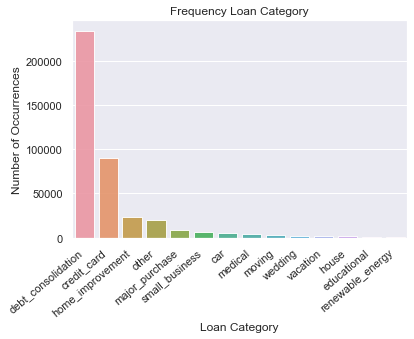

In [37]:
loan_cat = df_train['X17'].value_counts()
sns.set(style="darkgrid")
ax = sns.barplot(loan_cat.index, loan_cat.values, alpha=0.9,)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right") #make the x axis readable 
plt.title('Frequency Loan Category')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan Category', fontsize=12)
plt.show()

In [38]:
df_train = pd.get_dummies(df_train, columns = ['X17'])
df_test = pd.get_dummies(df_test, columns = ['X17'])

In [39]:
df_train = df_train.drop(['X17_car', 'X17_home_improvement','X17_small_business', 'X17_major_purchase', 'X17_other', 'X17_house', 'X17_vacation',
'X17_educational', 'X17_moving', 'X17_wedding', 'X17_medical','X17_renewable_energy'], axis = 1)

In [40]:
df_test = df_test.drop(['X17_car', 'X17_home_improvement',
'X17_small_business', 'X17_major_purchase', 'X17_other', 'X17_house', 'X17_vacation',
'X17_moving', 'X17_wedding', 'X17_medical', 'X17_renewable_energy'], axis = 1)

X20 --> since no missing value --> one hot encoding --> delete useless columns (any counts below 1000)

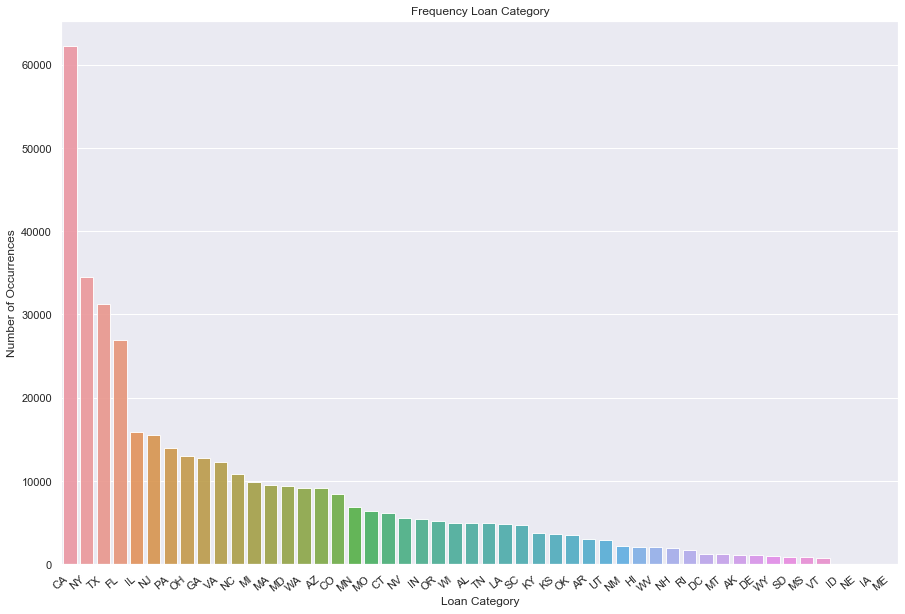

In [41]:
fig = plt.figure(figsize=(15,10)) #enlarge the plot
loan_cat = df_train['X20'].value_counts()
sns.set(style="darkgrid")
ax = sns.barplot(loan_cat.index, loan_cat.values, alpha=0.9,)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right") #make the x axis readable 
plt.title('Frequency Loan Category')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan Category', fontsize=12)
plt.show()

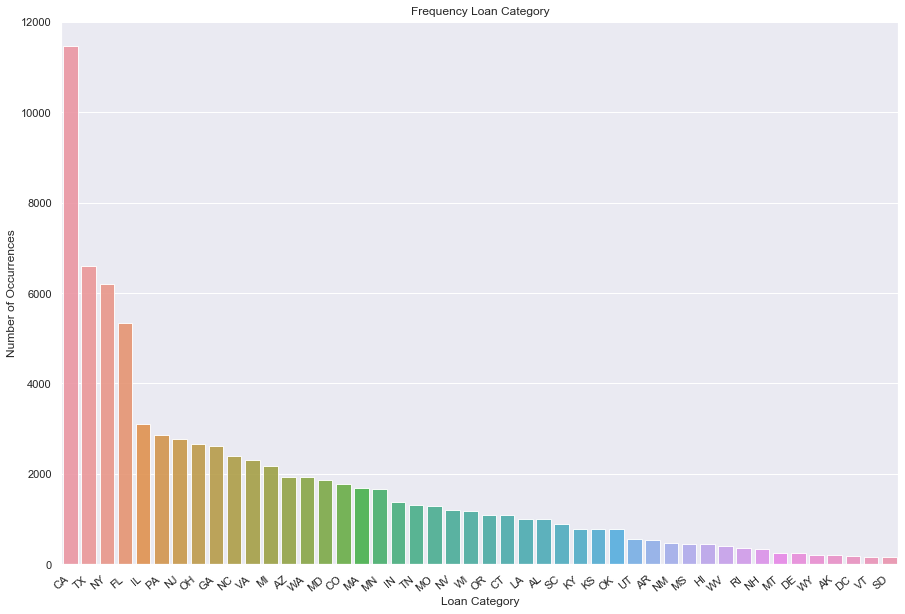

In [42]:
fig = plt.figure(figsize=(15,10)) #enlarge the plot
loan_cat = df_test['X20'].value_counts()
sns.set(style="darkgrid")
ax = sns.barplot(loan_cat.index, loan_cat.values, alpha=0.9,)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right") #make the x axis readable 
plt.title('Frequency Loan Category')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan Category', fontsize=12)
plt.show()

In [43]:
train_state = df_train['X20'].value_counts().index[df_train['X20'].value_counts().values > 10000]
test_state = df_test['X20'].value_counts().index[df_test['X20'].value_counts().values > 2200] #to make two lists identical 
print(train_state)
print(test_state)

Index(['CA', 'NY', 'TX', 'FL', 'IL', 'NJ', 'PA', 'OH', 'GA', 'VA', 'NC'], dtype='object')
Index(['CA', 'TX', 'NY', 'FL', 'IL', 'PA', 'NJ', 'OH', 'GA', 'NC', 'VA'], dtype='object')


In [44]:
df_train = pd.get_dummies(df_train, columns = ['X20'])
df_test = pd.get_dummies(df_test, columns = ['X20'])

In [45]:
df_train = df_train.drop(['X20_MI','X20_AZ','X20_AZ','X20_WA','X20_MD','X20_CO','X20_MA','X20_MN','X20_IN','X20_TN','X20_MO',
                         'X20_NV','X20_WI','X20_OR','X20_CT','X20_LA','X20_AL','X20_SC','X20_KY','X20_KS','X20_OK','X20_UT',
                         'X20_AR','X20_NM','X20_MS','X20_HI','X20_WV','X20_RI','X20_NH','X20_MT','X20_DE','X20_WY','X20_AK',
                          'X20_DC','X20_VT','X20_SD','X20_ME','X20_IA','X20_ID','X20_NE'], axis = 1)

In [46]:
df_test = df_test.drop(['X20_MI','X20_AZ','X20_AZ','X20_WA','X20_MD','X20_CO','X20_MA','X20_MN','X20_IN','X20_TN','X20_MO',
                         'X20_NV','X20_WI','X20_OR','X20_CT','X20_LA','X20_AL','X20_SC','X20_KY','X20_KS','X20_OK','X20_UT',
                         'X20_AR','X20_NM','X20_MS','X20_HI','X20_WV','X20_RI','X20_NH','X20_MT','X20_DE','X20_WY','X20_AK',
                          'X20_DC','X20_VT','X20_SD'], axis = 1)

X1 --> dropping null target responses 

In [47]:
df_train = df_train[df_train['X1'].notnull()] # droping NA value in the train data

x19 --> dropping columns as we already have state informaiton. 

In [48]:
df_train = df_train.drop('X19', axis = 1)
df_test = df_test.drop('X19', axis = 1)

x32 --> dropping columns as no further useful information was given and have low correlation with 


In [49]:
data = [df_train, df_test]
for dataset in data:
    dataset.X32 = dataset.X32.replace('f','0',regex = True)
    dataset.X32 = dataset.X32.replace('w','1',regex = True)
    dataset.X32 = dataset.X32.astype(int) 

In [50]:
np.corrcoef(df_train.X32,df_train.X1)

array([[ 1.       , -0.0097292],
       [-0.0097292,  1.       ]])

In [51]:
df_train = df_train.drop('X32', axis = 1)
df_test = df_test.drop('X32', axis = 1)

X30 ---> impute with mean since only 250 missing values 

In [52]:
fillvalue131 = np.nanmean(df_train['X30'])
df_train['X30'].fillna(fillvalue131, inplace=True)

fillvalue132 = np.nanmean(df_test['X30'])
df_test['X30'].fillna(fillvalue132, inplace=True)

check correlations between remained features - train_data

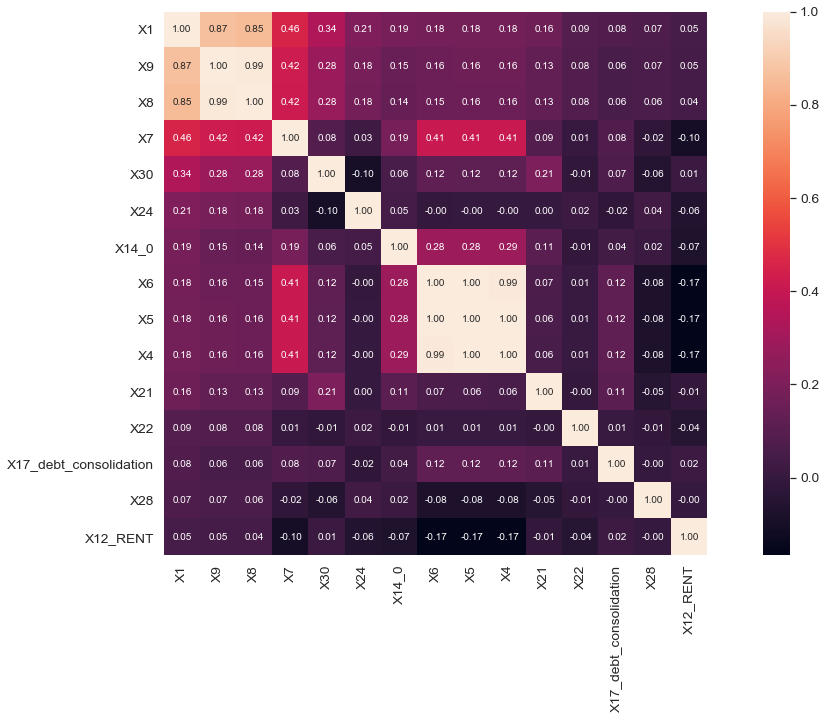

In [53]:
corrmat = df_train.corr()
plt.figure(figsize=(20,10))
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'X1')['X1'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [54]:
#df_train.to_csv('final.csv')

In [55]:
data_missing=cal_missing_val(df_train)
data_missing.sort_values(by=["MissingValue"], ascending = False).head()

,MissingValue
X1,0.0
X11_7,0.0
X11_9,0.0
X12_MORTGAGE,0.0
X12_OWN,0.0


# Final look of Train_set and Test_set

In [56]:
df_train.head()

,X1,X4,X5,X6,X7,X8,X9,X13,X21,X22,...,X20_FL,X20_GA,X20_IL,X20_NC,X20_NJ,X20_NY,X20_OH,X20_PA,X20_TX,X20_VA
0,0.1189,25000.0,25000.0,19080.0,0,2.0,24.0,85000.0,19.48,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.1071,7000.0,7000.0,673.0,0,2.0,25.0,65000.0,14.29,0.0,...,0,0,0,0,0,1,0,0,0,0
2,0.1699,25000.0,25000.0,24725.0,0,4.0,43.0,70000.0,10.50,0.0,...,0,0,0,0,0,1,0,0,0,0
3,0.1311,1200.0,1200.0,1200.0,0,3.0,32.0,54000.0,5.47,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.1357,10800.0,10800.0,10692.0,0,3.0,33.0,32000.0,11.63,0.0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
df_test.head()

,X1,X4,X5,X6,X7,X8,X9,X13,X21,X22,...,X20_FL,X20_GA,X20_IL,X20_NC,X20_NJ,X20_NY,X20_OH,X20_PA,X20_TX,X20_VA
0,NaN,6000.0,6000.0,6000.0,0,3,35,68000.0,28.31,0,...,0,0,0,0,0,0,1,0,0,0
1,NaN,24000.0,24000.0,24000.0,0,1,11,110480.0,16.03,0,...,0,0,0,0,0,0,0,0,0,0
2,NaN,35000.0,35000.0,35000.0,0,3,32,86000.0,32.49,0,...,0,0,0,0,0,0,0,1,0,0
3,NaN,10000.0,10000.0,10000.0,1,4,41,30000.0,32.96,0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,24000.0,24000.0,24000.0,1,2,21,82500.0,31.03,0,...,0,0,0,0,0,0,0,1,0,0


# Data Pre-processing: 

In [58]:
#Splitting train data into validation and train
from sklearn.model_selection import train_test_split
X_train = df_train.drop("X1", axis=1)
Y_train = df_train["X1"]
X_test = df_test.drop('X1', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(X_train,Y_train,test_size=0.2,random_state=0)

# Model 1 - Random Forest Regressor 

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate

In [60]:
# Train and Test score
rf = RandomForestRegressor(n_estimators=200, criterion = "mse", max_depth = 10, min_samples_split = 3, bootstrap= True, min_samples_leaf = 3, max_features = "sqrt")
rf.fit(x_train, y_train)
y_train_pred = rf.predict(x_train)
y_test_pred = rf.predict(x_test)
rmse_test = MSE(y_test, y_test_pred)**(1/2)
rmse_train = MSE(y_train, y_train_pred)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))
print('Train set RMSE of rf: {:.2f}'.format(rmse_train))

Test set RMSE of rf: 0.02
Train set RMSE of rf: 0.02


In [61]:
# CV score 
from sklearn.model_selection import cross_val_score
MSE_CV_scores_rf = - cross_val_score(rf, x_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 
RMSE_CV = (MSE_CV_scores_rf.mean())**(1/2)
print('CV RMSE: {:.2f}'.format(RMSE_CV)) 

CV RMSE: 0.02


* By comparing three RMSE score above, three RMSE are super close to each other, which indicates that the hyperparameters were good enough without tunning.

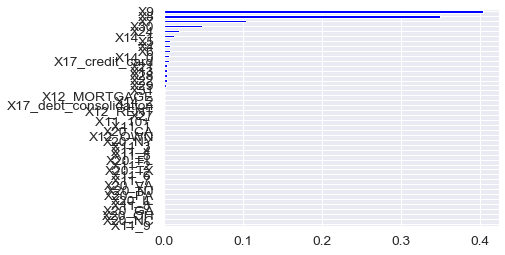

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
importances_rf = pd.Series(rf.feature_importances_,index = X_train.columns)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf.plot(kind='barh', color='blue')
plt.show()

In [63]:
importances_rf.sort_values(ascending = False).head(10)
#X9 X8, X7 are the most important. 

#We can consider dropping all the not useful columns in the future. 

X9       0.403226
X8       0.349381
X7       0.103393
X30      0.047738
X24      0.019407
X14_1    0.012361
X5       0.008348
X4       0.008076
X6       0.008040
X14_0    0.007096
dtype: float64

* code block below is to use randomizedSearchCV to find the optimal hyperparameters
* However, running takes more than 8 hours and still running without outputs. 
* As such, I manually compared RSME of CV,test and train and find relatively optimal hyperparameters.

In [64]:
'''
rf = RandomForestRegressor()
n_estimators = [50,100,200]
max_features = ['auto', 'sqrt']
max_depth = [2,5,10]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)
rf_random.best_params_               
'''

"\nrf = RandomForestRegressor()\nn_estimators = [50,100,200]\nmax_features = ['auto', 'sqrt']\nmax_depth = [2,5,10]\nmin_samples_split = [2, 5, 10]\nmin_samples_leaf = [1, 2, 4]\nbootstrap = [True, False]\nrandom_grid = {'n_estimators': n_estimators,\n               'max_features': max_features,\n               'max_depth': max_depth,\n               'min_samples_split': min_samples_split,\n               'min_samples_leaf': min_samples_leaf,\n               'bootstrap': bootstrap}\nrf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)\nrf_random.fit(x_train, y_train)\nrf_random.best_params_               \n"

# Model 2: XGBoost 

* Model running for hours without any responses. 

In [65]:
'''
import xgboost as xgb
model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 50, eval_metric = 'rmse', 
                early_stopping_rounds=100, 
                verbose_eval=100)
    
pred_test_y  = model.fit(x_train,y_train)
'''

"\nimport xgboost as xgb\nmodel = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,\n                max_depth = 5, alpha = 10, n_estimators = 50, eval_metric = 'rmse', \n                early_stopping_rounds=100, \n                verbose_eval=100)\n    \npred_test_y  = model.fit(x_train,y_train)\n"

In [66]:
'''
from sklearn.metrics import mean_squared_error as MSE
mse_test_XGB = MSE(y_test, y_rf_pred)
rmse_test_XGB = mse_test_XGB**(1/2)
print('Test set RMSE of rf: {:.15f}'.format(rmse_test_XGB))

'''

"\nfrom sklearn.metrics import mean_squared_error as MSE\nmse_test_XGB = MSE(y_test, y_rf_pred)\nrmse_test_XGB = mse_test_XGB**(1/2)\nprint('Test set RMSE of rf: {:.15f}'.format(rmse_test_XGB))\n\n"

# Model 3: GradientBoosting

In [73]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(max_depth=3,n_estimators=200,random_state=2)

In [74]:
# Test RMSE 
gb.fit(x_train, y_train)
y_pred_Gboost = gb.predict(x_test)
from sklearn.metrics import mean_squared_error as MSE
mse_test_Gboost = MSE(y_test, y_pred_Gboost)
rmse_test_Gboost = mse_test_Gboost**(1/2)
print('Test set RMSE of gb: {:.15f}'.format(rmse_test_Gboost))

Test set RMSE of gb: 0.016620288307501


In [75]:
# Train RMSE 
gb.fit(x_train, y_train)
y_train_pred = gb.predict(x_train)
mse_train_Gboost = MSE(y_train, y_train_pred)
rmse_train_Gboost = mse_train_Gboost**(1/2)
print('Train set RMSE of gb: {:.15f}'.format(rmse_train_Gboost))

Train set RMSE of gb: 0.016571786984900


In [76]:
# CV RMSE
from sklearn.model_selection import cross_val_score
MSE_CV_scores_gb = - cross_val_score(gb, x_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 
RMSE_CV_gb = (MSE_CV_scores_gb.mean())**(1/2)
print('CV RMSE gb: {:.2f}'.format(RMSE_CV_gb))   

CV RMSE gb: 0.02


* By comparing three RMSE score above under gb model (GradientBoostingRegressor(max_depth=4,n_estimators=200,random_state=2), three RMSE are super close to each other, but CV 0.02 is slightly higher than 0.016 which indicates that the hyperparameters may need some tuning to address the overfitting issue. (CV > Test)

* As such, I changed the hyperparameters to ensure CV Test Train RMSE are close enough to each other to rechieve the optimal hyperparameters.

# Model 4: LinearRegression 

In [77]:
#Train set RMSE 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold
import math
lr = LinearRegression()
lr.fit(x_train, y_train)
y_lg_pred_train =  lr.predict(x_train)
RMSE_lr_train = MSE(y_lg_pred_train, y_train)
RMSE_lr_train = RMSE_lr_train**(1/2)
print('Train set RMSE of LR: {:.15f}'.format(RMSE_lr_train))

Train set RMSE of LR: 0.020156029708478


In [78]:
#Test set RMSE 
lr = LinearRegression()
lr.fit(x_train, y_train)
y_lg_pred_test =  lr.predict(x_test)
RMSE_lr_test = MSE(y_lg_pred_test, y_test)
RMSE_lr_test = RMSE_lr_test**(1/2)
print('Train set RMSE of LR: {:.15f}'.format(RMSE_lr_test))

Train set RMSE of LR: 0.020100877699558


In [79]:
# CV RMSE
MSE_CV_scores_lr = - cross_val_score(lr, x_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 
RMSE_CV_lr = (MSE_CV_scores_lr.mean())**(1/2)
print('CV RMSE gb: {:.2f}'.format(RMSE_CV_lr))  

CV RMSE gb: 0.02


* By comparing three RMSE score above, three RMSE are super close to each other, which indicates that the hyperparameters were good enough without tunning.

* Although the RMSE is low enough, the QQ plot below show case that linear regression did not meet the normality assumption.
* As such, will not consider this model further

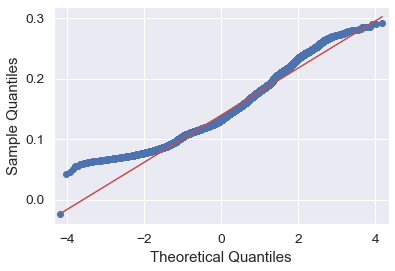

In [80]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
qqplot(y_lg_pred_test, line='s')
pyplot.show()

#  Model 5: Decision Tree

In [67]:
#Train RMSE

from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=5,min_samples_leaf=0.13,random_state=3)
dt.fit(x_train, y_train)
y_pred_dt_train = dt.predict(x_train)
RMSE_train_df = MSE(y_pred_dt_train, y_train)**(1/2)
print('Trian Set RMSE dt: {}'.format(RMSE_train_df))  

Trian Set RMSE dt: 0.022773583888544224


In [68]:
#Test RMSE

dt = DecisionTreeRegressor(max_depth=5,min_samples_leaf=0.13,random_state=3)
dt.fit(x_train, y_train)
y_pred_dt_test = dt.predict(x_test)
RMSE_test_df = MSE(y_pred_dt_test, y_test)**(1/2)
print('Test Set RMSE dt: {}'.format(RMSE_test_df))  

Test Set RMSE dt: 0.022791507892349638


In [69]:
# CV RMSE
MSE_CV_scores_dt = - cross_val_score(dt, x_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1) 
RMSE_CV_dt = (MSE_CV_scores_dt.mean())**(1/2)
print('CV RMSE dt: {}'.format(RMSE_CV_dt))  

CV RMSE dt: 0.02277678768101337


* Based on the comparison above all three RMSE above, CV is >> than both Test and train. As such, this is an problem of overfitting. 
* Considering using the randomsearchCV to find the optimal parameters below 

In [70]:
dt = DecisionTreeRegressor()
param_grid = {'max_depth': range(2,16,2),
              'min_samples_split': range(2,16,2)}
clf_random = RandomizedSearchCV(dt, param_grid,cv=5 , n_jobs=1, verbose=1)
clf_random.fit(x_train,y_train)
clf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.7min finished


{'min_samples_split': 2, 'max_depth': 10}

In [72]:
# Using the optimal parameters from the randomizedsearchCV above to Test RMSE

dt = DecisionTreeRegressor(min_samples_split = 10, max_depth = 10)
dt.fit(x_train, y_train)
y_pred_dt_test = dt.predict(x_test)
RMSE_test_df = MSE(y_pred_dt_test, y_test)**(1/2)
print('Test Set RMSE dt: {}'.format(RMSE_test_df))  

Test Set RMSE dt: 0.017168028365555008


# Models comparison summary

* All the models above are relatively equally working well for this dataset. Overall, Gradient Boost returned the more robust results with lower RMSE for this regression problem. 

* Model 1 - Random forest 
    * Pro: Tree based are easy to understand and interpret. The results are good on a large dataset with high accuracy on linear and nonlinear problem by boostrapping small sets and features to fit the data. 
    * Con: Takes time to find the optimal hyperparameters as the RandomizedsearchCV works slowly in a big dataset. 
    
* Model 2 - XGBoost  
    * Pro: N/A - Supposed to be a good candidate for this dataset. 
    * Con: Slow for big dataset, complex algorithms

* Model 3 - Gradient Boost 
    * Pro: Second hihgest score and lowests RMSE indicates good model. It takes several models are trianed sequentially with each model learning from the previous errors.It is also easy to interpret. 
    * Con: Overfitting problem still exist that may need to find the optimal hyperparameters to narrow down the gap between test, train and CV. Alternatively, we can use the randomizedsearchCV but worked slowly on the big data set. 
    
* Model 4 - Linear regression
    * Pro: Simply algorithm, Easy to implement and interpret. No too many assumption and parameters to tune the models.
    * Con: Model is too simplified and the data violates the normality assumption of normal distribution. 

* Model 5 - Decision tree
    * Pro: Tree model is easy to implement and interpret. Best RMSE score among all four models. No too many assumptions and parameters to tune the models.
    * Con: Usually the result is not as good as random forest due to decision tree is a single tree model.
    

# Final Conclusion:


In [81]:
a = df_test.columns.tolist()
x_holdout = a[1:len(a)] #remove X1 from the test for x_holdout

In [82]:
final_model = DecisionTreeRegressor(min_samples_split = 10, max_depth = 10)
final_model.fit(x_train,y_train)
y_pred_holdout = final_model.predict(df_test.loc[:,x_holdout])

In [83]:
result = pd.DataFrame(y_pred_holdout)
result.to_csv('result_Yiyan_Wan.csv')

# THE END 